### 1. SETUP Y CONFIGURACIÓN


##### 1.1 Imports

In [1]:
# Core
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Image processing
from PIL import Image
from skimage import color, io
import cv2

# Metrics
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Utils
import warnings
warnings.filterwarnings('ignore')

# Verificar versiones
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA available: True


##### 1.2 Configuración de Seeds


In [2]:
def set_seed(seed=42):
    """
    Configura seeds para reproducibilidad.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # para multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed configurada: {seed}")

# Aplicar seed
set_seed(42)

Seed configurada: 42


##### 1.3 Hiperparámetros Globales


In [3]:
class Config:
    """
    Configuración global del proyecto.
    """
    # Paths
    DATA_DIR = Path("data/raw")
    SAMPLES_DIR = Path("data/samples")
    
    # Dataset
    IMG_SIZE = 256  # Resolución de trabajo
    BATCH_SIZE = 32  # Ajustar según GPU
    NUM_WORKERS = 4  # Para DataLoader
    
    # Training
    NUM_EPOCHS = 50  # Ajustaremos según resultados
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    
    # Model
    BACKBONE = "resnet18"  # Opciones: resnet18, resnet50, vgg16
    PRETRAINED = True
    
    # Early stopping
    PATIENCE = 10
    
    # Reproducibilidad
    SEED = 42

config = Config()

print(" Configuración:")
print(f"  - Tamaño de imagen: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"  - Batch size: {config.BATCH_SIZE}")
print(f"  - Learning rate: {config.LEARNING_RATE}")
print(f"  - Backbone: {config.BACKBONE}")
print(f"  - Epochs: {config.NUM_EPOCHS}")

 Configuración:
  - Tamaño de imagen: 256x256
  - Batch size: 32
  - Learning rate: 0.001
  - Backbone: resnet18
  - Epochs: 50


### 2. EXPLORACIÓN Y PREPARACIÓN DEL DATASET



#### 2.1 Verificación del Dataset

In [4]:
# Dataset: Imagenette (descargado manualmente)
# URL: https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz

dataset_path = Path("data/raw/imagenette2-320")
assert dataset_path.exists(), "Dataset no encontrado. Descargar primero."

train_path = dataset_path / "train"
val_path = dataset_path / "val"

print("Dataset encontrado")
print(f"Train path: {train_path}")
print(f"Val path: {val_path}")

Dataset encontrado
Train path: data/raw/imagenette2-320/train
Val path: data/raw/imagenette2-320/val


#### 2.2 Exploración del Dataset


In [5]:
import glob

# Contar imágenes
train_images = glob.glob(str(train_path / "*" / "*.JPEG"))
val_images = glob.glob(str(val_path / "*" / "*.JPEG"))

print(f"Total imágenes de entrenamiento: {len(train_images)}")
print(f"Total imágenes de validación: {len(val_images)}")

# Clases disponibles
classes = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
print(f"\nNúmero de clases: {len(classes)}")
print(f"Clases: {classes}")

# Distribución por clase
print("\nDistribución por clase (train):")
for cls in classes:
    n_images = len(list((train_path / cls).glob("*.JPEG")))
    print(f"  {cls}: {n_images} imágenes")

Total imágenes de entrenamiento: 9469
Total imágenes de validación: 3925

Número de clases: 10
Clases: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

Distribución por clase (train):
  n01440764: 963 imágenes
  n02102040: 955 imágenes
  n02979186: 993 imágenes
  n03000684: 858 imágenes
  n03028079: 941 imágenes
  n03394916: 956 imágenes
  n03417042: 961 imágenes
  n03425413: 931 imágenes
  n03445777: 951 imágenes
  n03888257: 960 imágenes


#### 2.3 Mapeo de Clases


In [6]:
# Mapeo de IDs de ImageNet a nombres legibles
CLASS_NAMES = {
    'n01440764': 'tench (pez)',
    'n02102040': 'English springer (perro)',
    'n02979186': 'cassette player',
    'n03000684': 'chain saw',
    'n03028079': 'church (iglesia)',
    'n03394916': 'French horn',
    'n03417042': 'garbage truck',
    'n03425413': 'gas pump',
    'n03445777': 'golf ball',
    'n03888257': 'parachute'
}

print("Clases del dataset:")
for idx, (code, name) in enumerate(CLASS_NAMES.items()):
    print(f"  {idx}: {name} ({code})")

Clases del dataset:
  0: tench (pez) (n01440764)
  1: English springer (perro) (n02102040)
  2: cassette player (n02979186)
  3: chain saw (n03000684)
  4: church (iglesia) (n03028079)
  5: French horn (n03394916)
  6: garbage truck (n03417042)
  7: gas pump (n03425413)
  8: golf ball (n03445777)
  9: parachute (n03888257)


#### 2.4 Visualización de Ejemplos RGB


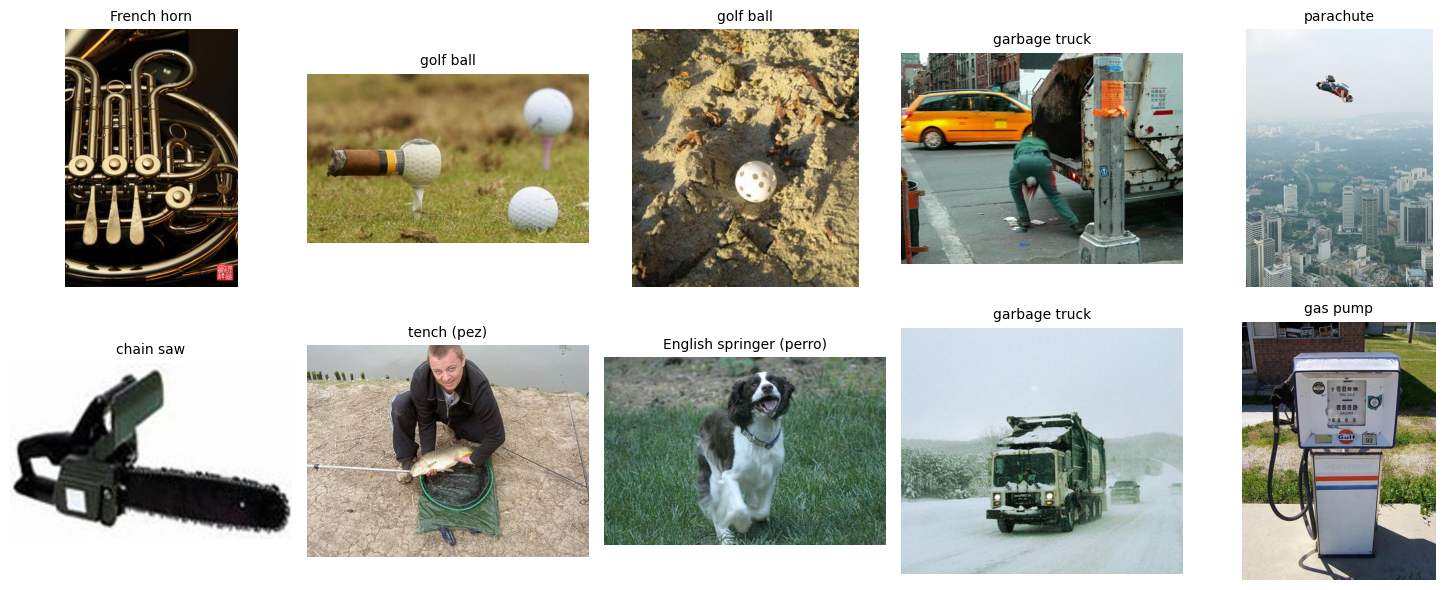

In [7]:
def visualize_random_samples(n_samples=10):
    """
    Visualiza muestras aleatorias del dataset.
    """
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    random_images = np.random.choice(train_images, n_samples, replace=False)
    
    for idx, img_path in enumerate(random_images):
        img = Image.open(img_path).convert('RGB')
        
        # Obtener clase
        class_id = Path(img_path).parent.name
        class_name = CLASS_NAMES.get(class_id, class_id)
        
        axes[idx].imshow(img)
        axes[idx].set_title(class_name, fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_random_samples(10)

In [ ]:
# ============================================
# 2.5 Conversión RGB → Grayscale → LAB
# ============================================

def visualize_color_spaces(n_samples=3):
    """
    Visualiza el proceso de conversión de espacios de color.
    """
    random_images = np.random.choice(train_images, n_samples, replace=False)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    
    for row, img_path in enumerate(random_images):
        # Cargar imagen RGB
        img_rgb = np.array(Image.open(img_path).convert('RGB')) / 255.0
        
        # Convertir a LAB
        img_lab = color.rgb2lab(img_rgb)
        
        # Extraer canales
        L = img_lab[:, :, 0]  # Luminosidad (grayscale)
        a = img_lab[:, :, 1]  # Canal a
        b = img_lab[:, :, 2]  # Canal b
        
        # Obtener clase
        class_id = Path(img_path).parent.name
        class_name = CLASS_NAMES.get(class_id, class_id)
        
        # Plot
        axes[row, 0].imshow(img_rgb)
        axes[row, 0].set_title(f'RGB Original\n{class_name}')
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(L, cmap='gray')
        axes[row, 1].set_title('Canal L (Luminosidad)\nInput del modelo')
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(a, cmap='RdYlGn_r')
        axes[row, 2].set_title('Canal a (verde-rojo)\nOutput 1')
        axes[row, 2].axis('off')
        
        axes[row, 3].imshow(b, cmap='YlGnBu_r')
        axes[row, 3].set_title('Canal b (azul-amarillo)\nOutput 2')
        axes[row, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_color_spaces(3)